**Author:** Talha Zahid  
**Course:** Practical Urban Data Science  
**Focus:** Cyclist Accident Hotspots  
**Dataset:** Berlin Traffic Accident Data 2021

**Table of Contents**

# **Urban Technologies Project – Full Project Plan (Revised)**

---

## **PHASE 1 – PROJECT SETUP**

### **1. Problem Definition**
- **Focus:** Identification of cyclist accident hotspots in Berlin  
- **Motivation:** Improve road safety and support urban infrastructure planning  
- **Stakeholders:** Berlin Traffic Safety Authority / Urban Mobility Planners  

### **2. Data Source Understanding**
- **Dataset:** Berlin Traffic Accidents (2021)  
- **Structure:** Multiple variables including temporal (year, month), spatial (coordinates), severity, and participant indicators  
- **Initial data quality assessment:** Performed  

---

## **PHASE 2 – DATA ACQUISITION**

### **3. Load Data**
- Imported CSV file (semicolon-delimited format)  
- Inspected columns, data types, and overall structure  

### **4. Metadata Documentation**
- Studied meanings of key variables (e.g., `IstRad`, `UKATEGORIE`)  
- Confirmed coordinate fields and coordinate reference system (WGS84 longitude/latitude)  

---

## **PHASE 3 – DATA CLEANING & PROCESSING**

### **5. Structural Cleaning**
- Corrected malformed column name: `YGCSWGS84,,,,` → `YGCSWGS84`  
- Standardized column names for consistency  

### **6. Coordinate Cleaning**
- Converted German decimal commas to floating-point values  
- Removed rows with invalid or missing geographic coordinates  

### **7. Logical Cleaning**
- Verified and standardized accident severity categories  
- Checked temporal variables available in the dataset  
- Identified and documented missing temporal resolution (no hour or weekday data)  

---

## **PHASE 4 – DATA FILTERING**

### **8. Extract Cyclist Accidents**
- Applied filter: `IstRad == 1`  
- **Result:** 4,248 cyclist-related accidents retained for analysis  

### **9. Severity Subgrouping (Future Work)**
- Fatal vs. serious vs. slight accidents  
- Enables prioritization of high-risk locations  

---

## **PHASE 5 – GEO-SPATIAL PROCESSING**

### **10. Create Geometry**
- Converted longitude/latitude pairs into Shapely `Point` objects  

### **11. Build GeoDataFrame**
- Added geometry column  
- Assigned coordinate reference system: **EPSG 4326 – WGS84**  

### **12. Spatial Validity Checks**
- Verified that all points fall within Berlin boundaries  
- Generated initial spatial visualization of cyclist accident locations  

---

## **PHASE 6 – EXPLORATORY DATA ANALYSIS**

### **13. Temporal Analysis**
- Distribution of cyclist accidents by month  
- Analysis of seasonal patterns  
- *(Hourly and weekday analysis not possible due to missing data)*  

### **14. Severity Analysis**
- Comparison of accident severity levels (fatal, serious, slight injuries)  
- Exploration of severity patterns across space and time  

### **15. Spatial Density Analysis**
- Exploration of spatial point distribution  
- Kernel Density Estimation (KDE) heatmaps to identify high-density areas  

---

## **PHASE 7 – HOTSPOT DETECTION (Future Work)**

### **16. DBSCAN Clustering**
- Reproject data to a metric CRS (**EPSG:25833 – meters**)  
- Normalize distance metrics  
- Detect clusters of high cyclist accident concentration  
- Assign hotspot labels  

### **17. Hotspot Visualization**
- Plot detected clusters on a Berlin map  
- Highlight high-risk intersections and road segments  

### **18. Ranking of Hotspots**
- Rank hotspots based on accident frequency and severity  
- Generate intersection-level summaries  

---

## **PHASE 8 – INSIGHTS, RECOMMENDATIONS & REPORTING (Future Work)**

### **19. Insights**
- Identification of seasonal risk patterns  
- List of most dangerous cyclist locations  
- District-level risk comparison  

### **20. Recommendations**
- Targeted infrastructure upgrades  
- High-priority areas for protected cycling lanes  
- Improvements in intersection design, signage, and visibility  

### **21. Final Deliverables**
- Fully documented Jupyter/Colab notebook  
- Hotspot visualizations and geospatial maps  
- Slide deck for final presentation  
- Executive summary with findings and recommendations  

---

## **22. Dataset Details**
- **Source:** Berlin Open Data Portal  
- **URL:** https://daten.berlin.de  


**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

from sklearn.cluster import DBSCAN

pd.set_option('display.max_columns', None)

**Load Dataset**

In [2]:

from google.colab import files
uploaded = files.upload()

Saving AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2021_Datensatz.csv to AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2021_Datensatz.csv


In [3]:
df = pd.read_csv(
    next(iter(uploaded.keys())),
    sep=';'
)

df.head()

,OBJECTID,LAND,BEZ,LOR_ab_2021,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,UART,UTYP1,ULICHTVERH,IstRad,IstPKW,IstFuss,IstKrad,IstGkfz,IstSonstige,USTRZUSTAND,LINREFX,LINREFY,XGCSWGS84,"YGCSWGS84,,,,"
0,219249,11,3,3701658.0,2021,11,18,2,3,0,3,2,0,1,0,1,0,0,1,"800202,0742","5829640,204","13,42689483","52,53393955"
1,219248,11,7,7501134.0,2021,12,19,7,3,6,2,2,0,1,1,0,0,0,1,"798479,5317","5819049,219","13,39209027","52,43995086"
2,219247,11,4,4100101.0,2021,12,17,4,3,5,2,2,0,1,0,0,0,0,0,"793352,6128","5829680,195","13,32624193","52,53802784"
3,219246,11,4,4501041.0,2021,12,15,7,3,5,2,1,0,1,0,1,0,0,1,"792950,0395","5825362,081","13,31652064","52,49953417"
4,219243,11,11,11501339.0,2021,12,9,5,3,3,6,0,0,1,0,0,0,1,2,"807182,01","5825602,793","13,52575163","52,49386714"


**Fix Incorrect Column Names**

In [4]:
df = df.rename(columns={"YGCSWGS84,,,,": "YGCSWGS84"})

**Convert German Decimal Format to Standard Floating-Point Numbers**

In [5]:
def convert_german_number_to_float(series):
    s = series.astype(str).str.replace(",", ".", regex=False)
    # Remove any strange characters like spaces or trailing dots
    s = s.str.replace(r"[^0-9\.\-]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

df["XGCSWGS84"] = convert_german_number_to_float(df["XGCSWGS84"])
df["YGCSWGS84"] = convert_german_number_to_float(df["YGCSWGS84"])

df[["XGCSWGS84", "YGCSWGS84"]].head()

,XGCSWGS84,YGCSWGS84
0,13.426895,52.533940
1,13.392090,52.439951
2,13.326242,52.538028
3,13.316521,52.499534
4,13.525752,52.493867


**Remove Invalid Coordinate Rows**

In [6]:
df = df.dropna(subset=["XGCSWGS84", "YGCSWGS84"])

In [7]:
len(df)

11259

In [8]:
df_cyclists = df[df["IstRad"] == 1]
len(df_cyclists)

4248

**Create GeoDataFrame for Spatial Analysis**

In [9]:
geometry = [Point(xy) for xy in zip(df_cyclists["XGCSWGS84"], df_cyclists["YGCSWGS84"])]

gdf_cyclists = gpd.GeoDataFrame(df_cyclists, geometry=geometry)

gdf_cyclists.set_crs(epsg=4326, inplace=True)

gdf_cyclists.head()

,OBJECTID,LAND,BEZ,LOR_ab_2021,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,UART,UTYP1,ULICHTVERH,IstRad,IstPKW,IstFuss,IstKrad,IstGkfz,IstSonstige,USTRZUSTAND,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,geometry
18,219221,11,4,4500939.0,2021,12,18,4,3,5,2,1,1,1,0,0,0,0,0,"792439,7595","5824095,448",13.307913,52.488453,POINT (13.30791 52.48845)
24,219214,11,1,1100102.0,2021,12,9,2,3,0,5,0,1,1,0,0,0,0,1,"796973,1702","5826579,744",13.376700,52.508275,POINT (13.3767 52.50827)
38,219193,11,5,5100209.0,2021,12,18,4,3,5,2,2,1,1,0,0,0,0,0,"783320,2118","5830271,905",13.179228,52.548642,POINT (13.17923 52.54864)
40,219190,11,1,1100310.0,2021,12,12,6,3,1,5,0,1,1,0,0,0,0,0,"799021,6282","5828725,878",13.408721,52.526393,POINT (13.40872 52.52639)
41,219189,11,3,3601451.0,2021,12,17,5,2,5,3,2,1,1,0,0,0,0,0,"801364,4615","5829700,555",13.444035,52.533839,POINT (13.44403 52.53384)


**Visualize Cyclist Accident Locations on a Map of Berlin bold text**

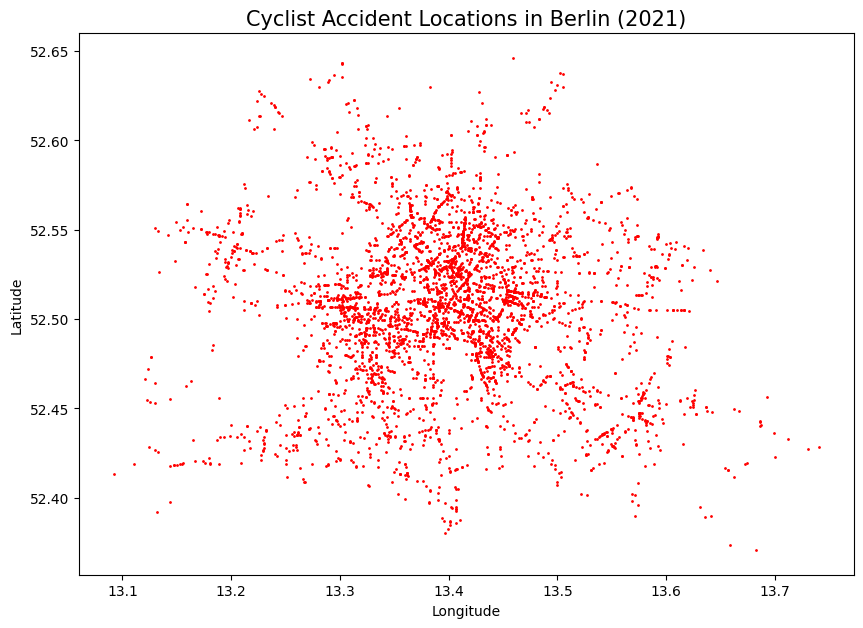

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cyclists.plot(ax=ax, markersize=1, color="red")

plt.title("Cyclist Accident Locations in Berlin (2021)", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

**Accidents by Month**


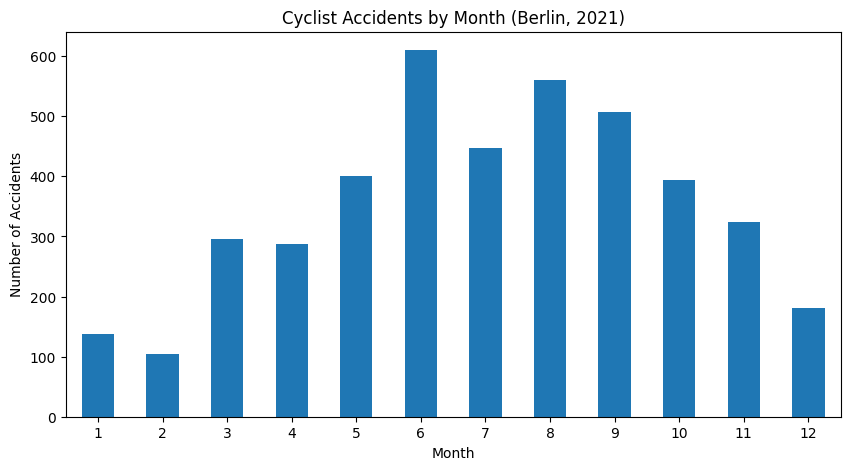

In [11]:
import matplotlib.pyplot as plt

accidents_by_month = gdf_cyclists["UMONAT"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
accidents_by_month.plot(kind="bar")

plt.title("Cyclist Accidents by Month (Berlin, 2021)")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=0)

plt.show()

**Severity Distribution**

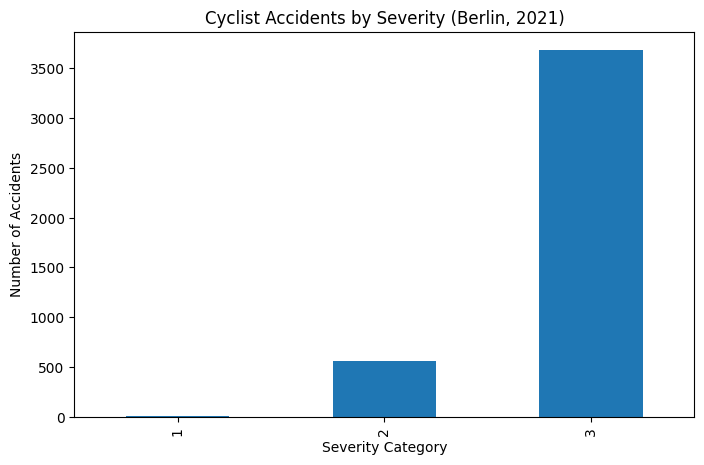

In [12]:
severity_counts = gdf_cyclists["UKATEGORIE"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
severity_counts.plot(kind="bar")

plt.title("Cyclist Accidents by Severity (Berlin, 2021)")
plt.xlabel("Severity Category")
plt.ylabel("Number of Accidents")

plt.show()


**KDE Heatmap**

In [13]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

x = gdf_cyclists.geometry.x
y = gdf_cyclists.geometry.y

coords = np.vstack([x, y])

In [14]:
kde = gaussian_kde(coords)

In [15]:
xmin, ymin, xmax, ymax = gdf_cyclists.total_bounds

xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
grid_coords = np.vstack([xx.ravel(), yy.ravel()])


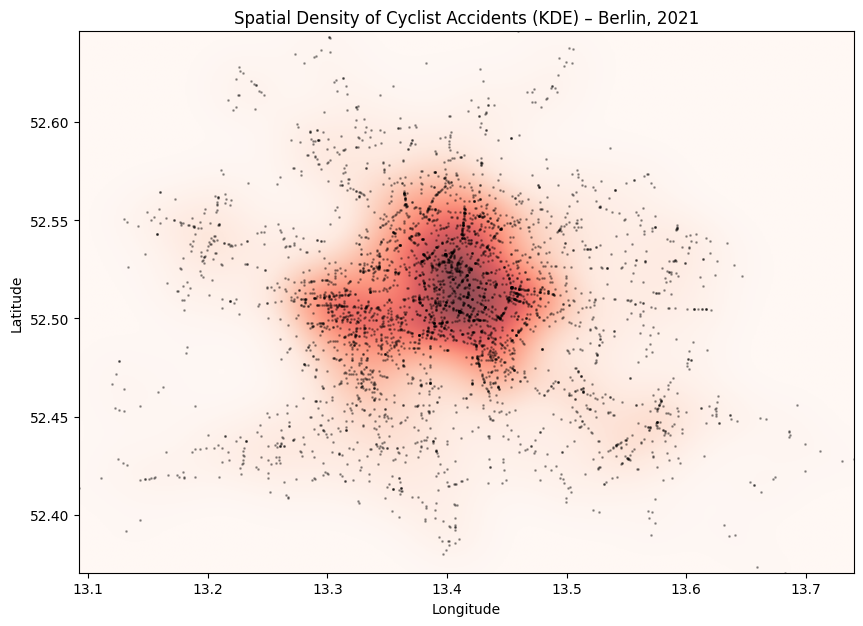

In [16]:
z = kde(grid_coords).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(
    z.T,
    extent=[xmin, xmax, ymin, ymax],
    origin="lower",
    cmap="Reds",
    alpha=0.7
)

# Overlay accident points
gdf_cyclists.plot(ax=ax, markersize=1, color="black", alpha=0.3)

plt.title("Spatial Density of Cyclist Accidents (KDE) – Berlin, 2021")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


**Hotspot Detection**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [18]:
# -----------------------------
# STEP 1 — Reproject to Metric CRS (Meters)
# -----------------------------
# DBSCAN works with distances, so we need meters instead of degrees
gdf_projected = gdf_cyclists.to_crs(epsg=25833)
print("CRS after reprojection:", gdf_projected.crs)

CRS after reprojection: EPSG:25833


In [19]:
# -----------------------------
# STEP 2 — Extract Coordinates for Clustering
# -----------------------------
# Convert geometry into numerical array for DBSCAN
coords = np.array([
    gdf_projected.geometry.x,
    gdf_projected.geometry.y
]).T

print("Coordinate shape for DBSCAN:", coords.shape)

Coordinate shape for DBSCAN: (4248, 2)


In [20]:
# -----------------------------
# STEP 3 — Run DBSCAN
# -----------------------------
# Parameters:
# eps = 100 meters → radius for neighborhood
# min_samples = 10 → minimum accidents to form a hotspot
dbscan = DBSCAN(eps=100, min_samples=10)

# Assign cluster labels
gdf_projected["cluster"] = dbscan.fit_predict(coords)

In [21]:
# -----------------------------
# STEP 4 — Basic Cluster Summary
# -----------------------------
print("\nCluster distribution:")
print(gdf_projected["cluster"].value_counts())


Cluster distribution:
cluster
-1    4141
 1      24
 0      18
 4      16
 6      16
 5      12
 3      11
 2      10
Name: count, dtype: int64


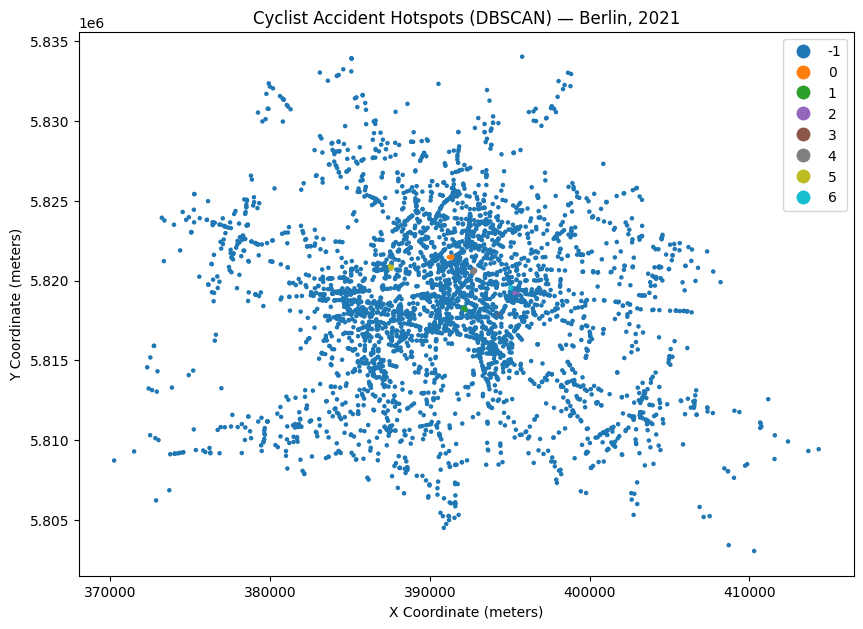

In [22]:
# -----------------------------
# STEP 5 — Visualize Hotspots
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 10))

gdf_projected.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    legend=True,
    markersize=5
)

plt.title("Cyclist Accident Hotspots (DBSCAN) — Berlin, 2021")
plt.xlabel("X Coordinate (meters)")
plt.ylabel("Y Coordinate (meters)")

plt.show()

In [23]:
# -----------------------------
# STEP 6 — Rank Hotspots by Size
# -----------------------------
hotspot_summary = (
    gdf_projected[gdf_projected["cluster"] != -1]
    .groupby("cluster")
    .size()
    .sort_values(ascending=False)
)

print("\nHotspot Ranking (by number of accidents):")
print(hotspot_summary)



Hotspot Ranking (by number of accidents):
cluster
1    24
0    18
4    16
6    16
5    12
3    11
2    10
dtype: int64


In [24]:
# -----------------------------
# STEP 7 — Optional: Add Severity-Based Ranking
# -----------------------------
# This ranks hotspots using weighted severity if you want extra academic strength

severity_weights = {
    1: 3,  # Fatal
    2: 2,  # Serious injury
    3: 1   # Slight injury
}

gdf_projected["severity_score"] = gdf_projected["UKATEGORIE"].map(severity_weights)

severity_ranking = (
    gdf_projected[gdf_projected["cluster"] != -1]
    .groupby("cluster")["severity_score"]
    .sum()
    .sort_values(ascending=False)
)

print("\nHotspot Ranking (by severity impact score):")
print(severity_ranking)


Hotspot Ranking (by severity impact score):
cluster
1    27
0    19
6    19
4    16
5    14
3    13
2    11
Name: severity_score, dtype: int64


In [25]:
# Convert back to lon/lat for web map display
gdf_web = gdf_projected.to_crs(epsg=4326).copy()
gdf_web["lon"] = gdf_web.geometry.x
gdf_web["lat"] = gdf_web.geometry.y

# Keep only required columns
cols = ["lon", "lat", "UMONAT", "UKATEGORIE", "cluster"]
gdf_web[cols].to_csv("accidents_with_clusters.csv", index=False)

print("Saved accidents_with_clusters.csv")

✅ Saved accidents_with_clusters.csv


In [26]:
import pandas as pd

hotspots = (
    gdf_projected[gdf_projected["cluster"] != -1]
    .groupby("cluster")
    .size()
    .reset_index(name="accident_count")
    .sort_values("accident_count", ascending=False)
)

hotspots.to_csv("hotspots.csv", index=False)

display(hotspots.head())

✅ Saved hotspots.csv


,cluster,accident_count
1,1,24
0,0,18
4,4,16
6,6,16
5,5,12
